# Classification using dense neural network (fully connected)
For this exercise we'll be using [Keras](https://keras.io/).. In addition you need either [TensorFlow](https://www.tensorflow.org/) or [PyTorch](https://pytorch.org/)
as the underlying framework. Or, you can also continue with scikit-learn, which also has dense / fully connected networks implemented.

## Normalization of image data
We apply the same normalization as for logistic regression. Recall that we have saved this function in a file
called `helper_functions.py`, and can import and use it directly from there.

## Numpy approach

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from sklearn.model_selection import train_test_split
from helper_functions import normalize_image_data

Using TensorFlow backend.


In [3]:
# Load images and labels.
DATA_PATH = "../data/"

images = np.load(DATA_PATH+"images_training.npy")
labels = np.load(DATA_PATH+"labels_training.npy")

# Just like with logistic regression, we need to reshape the images to
# be one-dimensional for the input to the model.
images = images.reshape(images.shape[0], 256)

# Split the training indices into training and validation. 
# Validate with 25% of the data (default). Can be adjusted.
x_idx = np.arange(images.shape[0])
train_idx, val_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.25)

### Build a model
We're going to start off with a simple feed-forward neural network one hidden layer. This is a binary classifier, so
we techincally only need it to output one number.

In [4]:
# Init the Sequential model
model = Sequential()
# Add Input layer
model.add(InputLayer(input_shape=(images.shape[1],)))

# Add hidden layer
model.add(Dense(64, activation='relu'))

# Add output layer.
model.add(Dense(1, activation='sigmoid'))

# Finally, compile the model and print a summary. Loss function and optimizer is set during compilation.
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 16,513
Trainable params: 16,513
Non-trainable params: 0
_________________________________________________________________


### Train the model
The fit() function returns a history object that we'll store to plot how the training developed with epochs.
First we need to set som training parameters.

Note that if you would like to change something about the the model and run training again, you must
re-compile the model. Otherwise you will essentially just be doubling the number of epochs.

In [5]:
# Set parameters for the training run. For the small set of 10k events you can probably get 
# away with even 100 epochs in a fairly small time, depending on your CPU.
epochs = 20
batch_size = 32

In [6]:
# The validation_data keywork expects a 'tuple' (val_x, val_y) so we make one on the fly
history = model.fit(
    x=normalize_image_data(images[train_idx]),
    y=labels[train_idx],
    validation_data=(normalize_image_data(images[val_idx]), labels[val_idx]),
    epochs=epochs,
    batch_size=batch_size,
)

Train on 6750 samples, validate on 2250 samples
Epoch 1/20
6750/6750 [==============================] - 1s 94us/step - loss: 0.5534 - accuracy: 0.7130 - val_loss: 0.4899 - val_accuracy: 0.7476
Epoch 2/20
6750/6750 [==============================] - 1s 78us/step - loss: 0.4890 - accuracy: 0.7413 - val_loss: 0.4795 - val_accuracy: 0.7520
Epoch 3/20
6750/6750 [==============================] - 1s 92us/step - loss: 0.4762 - accuracy: 0.7495 - val_loss: 0.4721 - val_accuracy: 0.7560
Epoch 4/20
6750/6750 [==============================] - 0s 73us/step - loss: 0.4637 - accuracy: 0.7541 - val_loss: 0.4654 - val_accuracy: 0.7569
Epoch 5/20
6750/6750 [==============================] - 1s 79us/step - loss: 0.4520 - accuracy: 0.7622 - val_loss: 0.4544 - val_accuracy: 0.7640
Epoch 6/20
6750/6750 [==============================] - 0s 73us/step - loss: 0.4391 - accuracy: 0.7754 - val_loss: 0.4470 - val_accuracy: 0.7689
Epoch 7/20
6750/6750 [==============================] - 1s 74us/step - loss: 0.425

### Evaluate the model
Let's use the history object to plot how the loss and accuracy changed during training.
The history contains a dictionary of the currently applied metrics as keys. In this case we have the
keys "loss", "accuracy", "val_loss", and "val_accuracy". "loss" and "accuracy" pertain to the training data, while
"val_loss" and "val_accuracy" are the metrics for the validation data we provided.

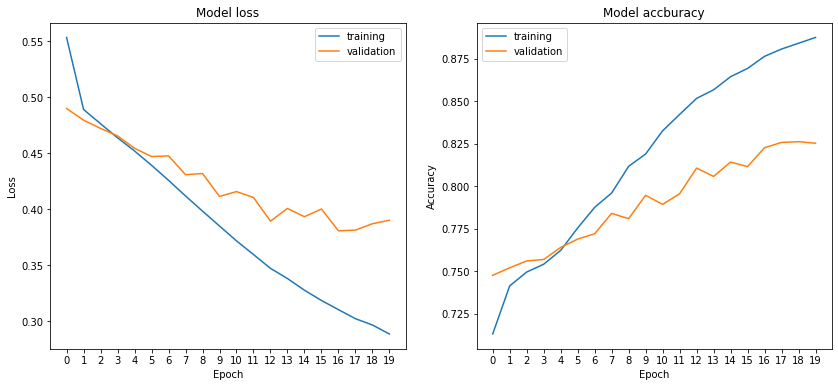

In [7]:
# Plot loss and val_loss as one plot, and accuracy and val_accuracy as another, side-by-side.
# We'll also save this plot as plot_history() in the helper_functions file, so any time we need to
# plot the history object like this we can just call that function and pass the history object as
# an argument.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
num_epochs = len(history.history['loss'])
ax[0].plot(history.history['loss'], label='training')
ax[0].plot(history.history['val_loss'], label='validation')
ax[0].set_title("Model loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_xticks(np.arange(num_epochs))
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='training')
ax[1].plot(history.history['val_accuracy'], label='validation')
ax[1].set_title("Model accburacy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_xticks(np.arange(num_epochs))
ax[1].legend()

The plotting function will only plot these two metrics regardless of how many other metrics we add to the model,
but it's a starting point that can be extended as you might add more metrics.

In [8]:
# Predict on the validation set
pred = model.predict([normalize_image_data(images[val_idx])])

## Confusion Matrix
The confusion matrix can be a useful metric to gain a little bit
more insight into specifically what the model gets wrong.
* Top left: Single events classified as single events
* Top right: Single events classified as double events
* Bottom left: Double events classified as single events
* Bottom right: Double events classified as double events

In [9]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
# Convert sigmoid values from prediction to integers so it works with the function.

result = pred > 0.5
confusion_matrix(labels[val_idx], result)

array([[1080,   12],
       [ 381,  777]])

## F1-Score

In [10]:
from sklearn.metrics import f1_score
score = f1_score(labels[val_idx], result)
print("F1-score: ", score)

F1-score:  0.7981510015408321


## ROC-Curve

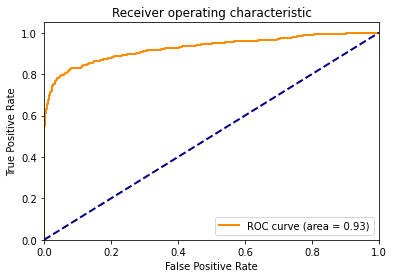

In [11]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(labels[val_idx], pred)
roc_auc = auc(fpr, tpr)
# Plot the curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label="ROC curve (area = {:0.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend()
plt.show()